## 1. Example of weather loading

In [1]:
import requests, sys
import geopandas as gpd
import geojson

sys.path.append('..')

# from pyc.aws_weather import NSI_ATD, AWS_WOFOST, AwsNasaPower

In [2]:
from pyCropModels.weather.aws_weather import AwsNasaPower, Aws_Wofost

/Users/mikhailgasanov/geo/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mikhailgasanov/geo/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
Platform not recognized, using system temp directory for PCSE settings.
Platform not recognized, using system temp directory for PCSE settings.


In [24]:
gdf = gpd.read_file('https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/GeoJSON/europe.geojson')
gdf = gdf.set_crs('EPSG:4326')

<AxesSubplot:>

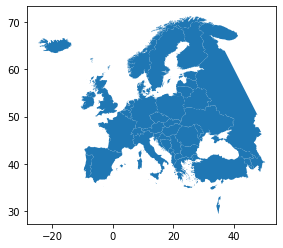

In [25]:
gdf.plot()

In [ ]:
from pyCropModels import CropModels
crop_model = CropModel(gdf=gdf)

crop_model.run_monica(weather = 'reanalysis', 
                      crop='wheat',
                      year='2020')


crop_model.run_monica(weather = 'SPS5.5',
                    crop='wheat',
                    year='2020-2040')

crop_model.run_monica(weather = 'climateSPS5.5', crop='barley',
                      year='2020')

crop_model.run_wofost(weather = 'climateSPS5.5', crop='wheat',
                      year='2020')

In [26]:
aws_loader = AwsNasaPower(gdf=gdf)


In [27]:
meteo_dataset = aws_loader.download(time_start = '2022-01-01', 
                            time_end='2022-12-31')


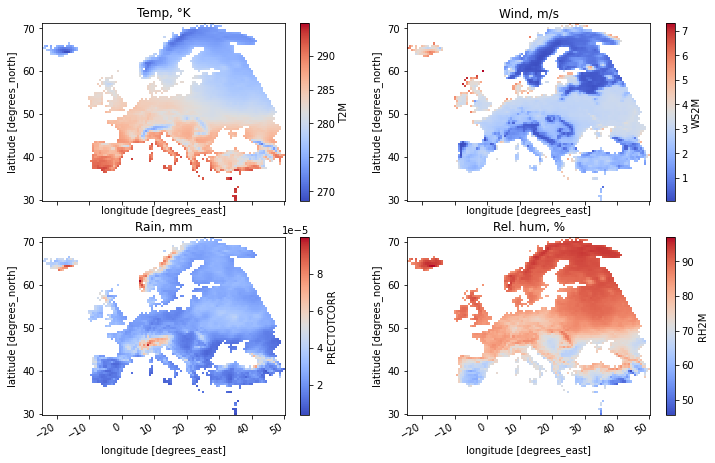

In [28]:
import matplotlib.pyplot as plt

ds_eu = meteo_dataset['meteo']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(12,8))
fig.autofmt_xdate()

target_plots = ["T2M",
             "WS2M",
             "PRECTOTCORR",
             'RH2M']

target_names = ["Temp, °K",
             "Wind, m/s",
             "Rain, mm",
             'Rel. hum, %']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    select = ds_eu.sel(time=slice('2022-01-01', '2022-12-31'))
    (select.mean(dim='time')[target_plots[i]]).plot(ax=ax, cmap='coolwarm')
    ax.set_title(target_names[i])

## WOFOST

In [29]:
wdp = Aws_Wofost(longitude=5,
            latitude=50,
            ds_solar=meteo_dataset['solar'],
            ds_weather=meteo_dataset['meteo'])

In [30]:
from pcse.db import nasapower

In [31]:
nasa = nasapower.NASAPowerWeatherDataProvider(longitude=5,latitude=50)

In [2]:
import pandas as pd
import datetime as dt
import json

import yaml
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

import seaborn as sns
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost71_WLP_FD, Wofost71_PP
from pcse.fileinput import CABOFileReader, YAMLCropDataProvider
from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import WOFOST71SiteDataProvider, DummySoilDataProvider
from pcse.base import ParameterProvider
from pcse.engine import Engine
from pcse.fileinput import csvweatherdataprovider

# from weather.weather_utils import weather_loader

Platform not recognized, using system temp directory for PCSE settings.
Platform not recognized, using system temp directory for PCSE settings.


Building PCSE demo database at: /var/folders/1f/xyznj37x1n337kxt0v5533rw0000gn/T/.pcse/pcse.db ... OK


In [3]:
soild = DummySoilDataProvider()

In [4]:
soild

{'SMFCF': 0.3,
 'SM0': 0.4,
 'SMW': 0.1,
 'RDMSOL': 120,
 'CRAIRC': 0.06,
 'K0': 10.0,
 'SOPE': 10.0,
 'KSUB': 10.0}

Text(0.5, 1.0, 'WOFOST')

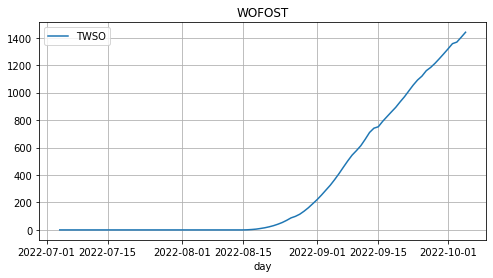

In [33]:
crop_name = 'soybean'
variety_name = 'Soybean_904'

cropd = YAMLCropDataProvider(repository="https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/master/")
sited = WOFOST71SiteDataProvider(WAV=50)

soild = DummySoilDataProvider()


sowing_date = "2022-07-04"
harvest_date = "2022-10-05"
_campaign_start_date_dt = parse(sowing_date) -  dt.timedelta(days=20)
campaign_start_date = dt.datetime.strftime(_campaign_start_date_dt, format='%Y-%m-%d')

max_duration = 130

# Here we define the agromanagement for crop
agro_yaml = f"""
- {campaign_start_date}:
    CropCalendar:
        crop_name: {crop_name}
        variety_name: {variety_name}
        crop_start_date: {sowing_date}
        crop_start_type: emergence
        crop_end_date: {harvest_date}
        crop_end_type: harvest
        max_duration: {max_duration}
    TimedEvents: null
    StateEvents: null
"""
agro = yaml.safe_load(agro_yaml)

firstkey = list(agro[0])[0]
cropcalendar = agro[0][firstkey]['CropCalendar'] 

cropd.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])

params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
model_runner = Wofost71_WLP_FD(params, wdp, agro)
model_runner.run_till_terminate()
r = model_runner.get_summary_output()
plot = model_runner.get_output()
df_aws = pd.DataFrame(plot)


fig, ax = plt.subplots(1,1, figsize=(8,4))
target_result = r[0]['TWSO']
df_aws.set_index('day')['TWSO'].plot(ax=ax, label='TWSO')
ax.grid()
ax.legend()
ax.set_title('WOFOST')


## Crop calendar

In [ ]:
url_sage = "https://drive.google.com/file/d/1Sad6O2nsuUW7af00X392HUjE0G5bvL1j/view?usp=sharing"

In [1]:
from sklearn.ensemble import RandomForestRegressor

In [2]:
RandomForestRegressor

sklearn.ensemble._forest.RandomForestRegressor